In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [2]:
price = pd.read_csv('./최종 부품 공임비.csv', encoding = 'utf-8')
price.head()

,id,brand,Breakage,Crushed,Scratched,Separated,repair,공임,Roof,Windshield,...,Head lights,Side mirror,Front fender,Front door,B pillar,Front Wheel,Rear fender,Front bumper,Undercarriage,Rear windshield
0,as-0000004,BMW,5846.5,0.0,224559.0,0.0,['Rear bumper'],1515360.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,as-0000005,CITROEN,0.0,0.0,397134.0,63774.5,"['Front bumper', 'Front door(R)', 'Head lights...",2827810.0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,as-0000009,BMW,0.0,0.0,9618.0,8546.5,"['Front bumper', 'Head lights', 'Front fender(...",2589760.0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,as-0000011,BMW,0.0,212174.5,1139922.5,182862.5,"['Rear Wheel(R)', 'Rear fender(R)', 'Rear door...",3945120.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,as-0000019,BENZ,50264.5,359841.0,25057.5,41248.5,"['Bonnet', 'Front door(L)']",1102500.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
len(price)

105848

In [4]:
X = price.drop('공임', axis=1)
y = price['공임'] 

# train, valid, test 데이터로 분할(8:1:1)
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

X_train_str = X_train.drop(['Breakage', 'Crushed', 'Scratched', 'Separated'], axis = 1)
X_valid_str = X_valid.drop(['Breakage', 'Crushed', 'Scratched', 'Separated'], axis = 1)
X_test_str = X_test.drop(['Breakage', 'Crushed', 'Scratched', 'Separated'], axis = 1)

X_train_num = X_train[['Breakage', 'Crushed', 'Scratched', 'Separated']]
X_valid_num = X_valid[['Breakage', 'Crushed', 'Scratched', 'Separated']]
X_test_num = X_test[['Breakage', 'Crushed', 'Scratched', 'Separated']]

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train_num)
X_valid_norm = scaler.transform(X_valid_num)
X_test_norm = scaler.transform(X_test_num)

X_train_norm = pd.DataFrame(X_train_norm, columns=X_train_num.columns)  # 훈련 데이터프레임으로 변환
X_valid_norm = pd.DataFrame(X_valid_norm, columns=X_valid_num.columns)  # 검증 데이터프레임으로 변환
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test_num.columns)  # 테스트 데이터프레임으로 변환

X_train_str.reset_index(inplace=True, drop=True)
X_valid_str.reset_index(inplace=True, drop=True)
X_test_str.reset_index(inplace=True, drop=True)


X_train_normalized = pd.concat([X_train_str, X_train_norm], axis = 1)
X_valid_normalized = pd.concat([X_valid_str, X_valid_norm], axis = 1)                                
X_test_normalized = pd.concat([X_test_str, X_test_norm], axis = 1)

In [27]:
print(len(X_train_normalized))
print(len(X_valid_normalized))
print(len(X_test_normalized))

84678
10585
10585


In [5]:
X_train_normalized = X_train_normalized.drop(['id','brand','repair'], axis = 1)
X_valid_normalized = X_valid_normalized.drop(['id','brand','repair'], axis = 1)
X_test_normalized = X_test_normalized.drop(['id','brand','repair'], axis = 1)

# 기본 XGBOOST

In [6]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train_normalized, y_train)

y_train_pred = xgb_model.predict(X_train_normalized)
y_valid_pred = xgb_model.predict(X_valid_normalized)
y_test_pred = xgb_model.predict(X_test_normalized)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 예측 결과 출력
print("검증 데이터에 대한 예측 결과:")
result_train = pd.DataFrame({'actual': y_train, 'pred':y_train_pred})
result_valid = pd.DataFrame({'actual' : y_valid, 'pred': y_valid_pred})

# RMSE 출력
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)
print("테스트 데이터에 대한 RMSE:", rmse_test)

검증 데이터에 대한 예측 결과:
훈련 데이터에 대한 RMSE: 292778.817668467
검증 데이터에 대한 RMSE: 318744.8730788003
테스트 데이터에 대한 RMSE: 353206.500713798


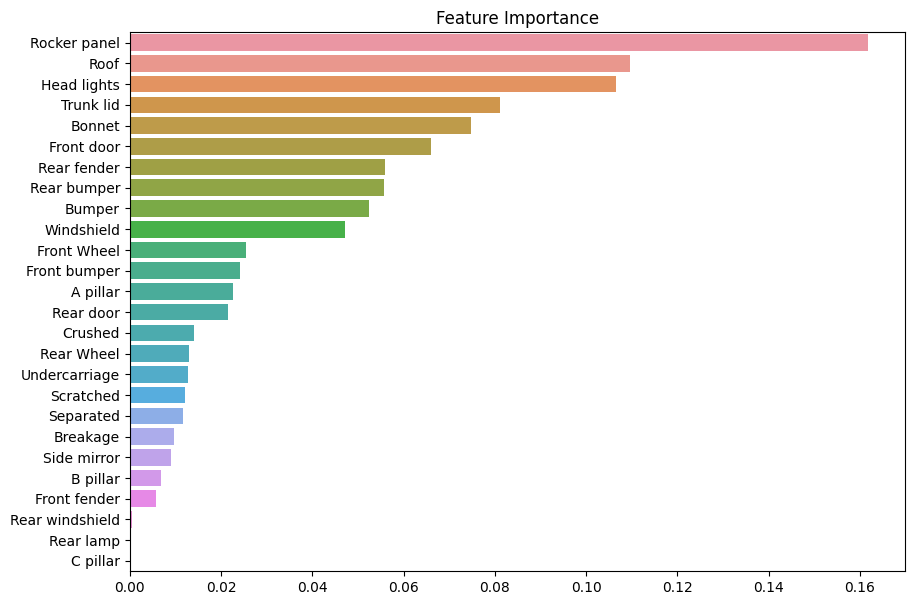

In [7]:
xgb_importance_values = xgb_model.feature_importances_

xgb_series = pd.Series(xgb_importance_values, index = X_train_normalized.columns)
xgb_series.sort_values(ascending = False, inplace = True)

plt.figure(figsize = (10,7))
plt.title('Feature Importance')
sns.barplot(x = xgb_series, y = xgb_series.index)
plt.show()

# XGBOOST 랜덤서치, K-FOLD CV

In [8]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# XGBoost 모델 정의
model = XGBRegressor()

# 하이퍼파라미터 분포 설정
param_dist = {
    'max_depth': randint(6, 10), 
    'n_estimators': randint(50, 200), 
    'learning_rate': uniform(0.01, 0.2),
    'gamma':uniform(0, 5)
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=kfold)

# 랜덤 서치 수행
random_search.fit(X_train_normalized, y_train)

# 최적의 하이퍼파라미터와 모델 성능 출력
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# 최적의 하이퍼파라미터로 학습된 모델 저장
best_model = random_search.best_estimator_

# best_model.save_model('best_model_xgb.model')
y_train_pred = best_model.predict(X_train_normalized)
y_valid_pred = best_model.predict(X_valid_normalized)
y_test_pred = best_model.predict(X_test_normalized)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# result_train = pd.DataFrame({'actual': y_train, 'pred':y_train_pred})
# result_valid = pd.DataFrame({'actual' : y_valid, 'pred': y_valid_pred})

print("검증 데이터에 대한 예측 결과:")
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)                    
print("테스트 데이터에 대한 RMSE:", rmse_test)

Best Parameters:  {'gamma': 0.5632298693616611, 'learning_rate': 0.08678088583846871, 'max_depth': 6, 'n_estimators': 165}
Best Score:  0.3709931104105785
검증 데이터에 대한 예측 결과:
훈련 데이터에 대한 RMSE: 308681.6654902415
검증 데이터에 대한 RMSE: 317592.8916230205
테스트 데이터에 대한 RMSE: 347683.77755271445


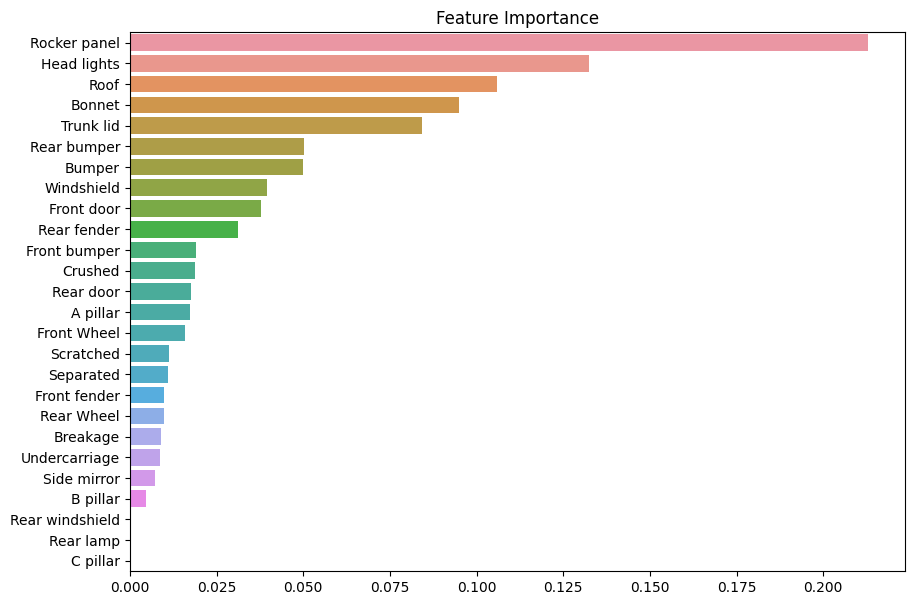

In [28]:
xgb_importance_values = best_model.feature_importances_

xgb_series = pd.Series(xgb_importance_values, index = X_train_normalized.columns)
xgb_series.sort_values(ascending = False, inplace = True)

plt.figure(figsize = (10,7))
plt.title('Feature Importance')
sns.barplot(x = xgb_series, y = xgb_series.index)
plt.show()

In [23]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [25]:
X_train_normalized.columns

Index(['Roof', 'Windshield', 'Bonnet', 'Bumper', 'C pillar', 'Rear bumper',
       'Rocker panel', 'Trunk lid', 'A pillar', 'Rear lamp', 'Rear door',
       'Rear Wheel', 'Head lights', 'Side mirror', 'Front fender',
       'Front door', 'B pillar', 'Front Wheel', 'Rear fender', 'Front bumper',
       'Undercarriage', 'Rear windshield', 'Breakage', 'Crushed', 'Scratched',
       'Separated'],
      dtype='object')

# lgbm 랜덤서치, K-FOLD CV

In [9]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
# LightGBM 모델 정의
lgbm = lgb.LGBMRegressor()

# 랜덤 서치를 위한 하이퍼파라미터 후보군 정의
param_dist = {
    'n_estimators': [100, 200, 300], # 트리 개수
    'max_depth': [10, 20, 30, -1], # 트리의 최대 깊이 (-1은 제한 없음)
    'learning_rate': [0.01, 0.05, 0.1], # 학습률
    'num_leaves': [31, 41, 51], # 각 트리의 최대 잎 노드 수
    'min_child_samples': [20, 30, 40] # 잎 노드에 필요한 최소한의 데이터 개수
}

# 랜덤 서치(RandomizedSearchCV) 객체 생성
lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error', # 평가 지표 (이 경우 평균 제곱 오차, 낮을수록 좋음)
    n_iter=10, # 랜덤 서치 반복 횟수
    cv=kfold # 교차 검증 폴드 수
)

# 랜덤 서치 수행
lgbm_random_search.fit(X_train_normalized, y_train)

best_lgbm_model = lgbm_random_search.best_estimator_

y_train_pred = best_lgbm_model.predict(X_train_normalized)
y_valid_pred = best_lgbm_model.predict(X_valid_normalized)

# 최적의 하이퍼파라미터와 모델 성능 출력
# print("최적의 하이퍼파라미터: ", best_lgbm_model.best_params_)
# print("최적의 모델 성능(RMSE): ", np.sqrt(np.abs(best_lgbm_model.best_score_)))

# 테스트 데이터로 예측 수행
y_test_pred = best_lgbm_model.predict(X_test_normalized)

# 테스트 데이터에 대한 예측 성능 출력
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("검증 데이터에 대한 예측 결과:")
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)                    
print("테스트 데이터에 대한 RMSE:", rmse_test)

검증 데이터에 대한 예측 결과:
훈련 데이터에 대한 RMSE: 334686.24682819896
검증 데이터에 대한 RMSE: 314554.1923086802
테스트 데이터에 대한 RMSE: 347689.08705331414


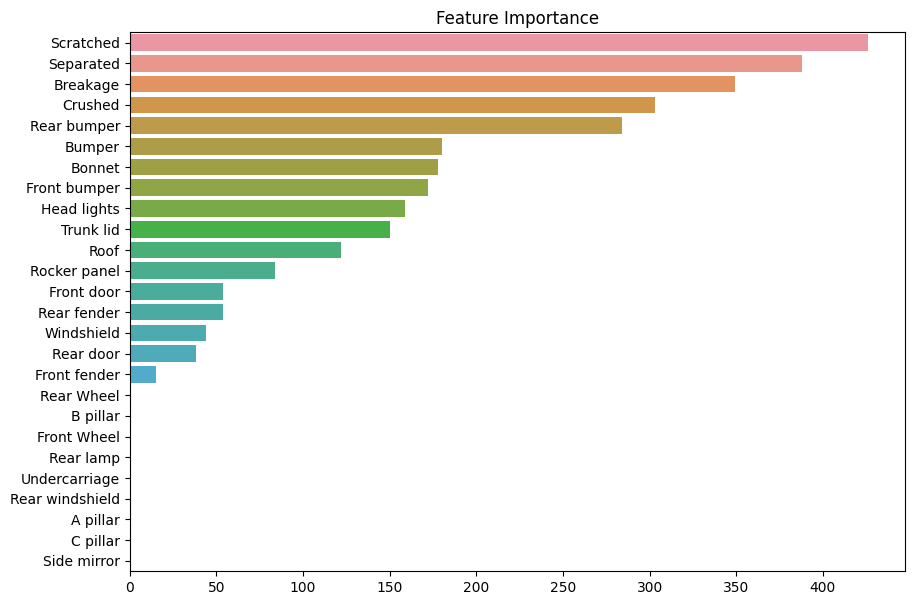

In [29]:
lgbm_importance_values = best_lgbm_model.feature_importances_

lgbm_series = pd.Series(lgbm_importance_values, index = X_train_normalized.columns)
lgbm_series.sort_values(ascending = False, inplace = True)

plt.figure(figsize = (10,7))
plt.title('Feature Importance')
sns.barplot(x = lgbm_series, y = lgbm_series.index)
plt.show()

# LGBM K-FOLD CV

In [31]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# LightGBM 데이터셋으로 변환
train_data = lgb.Dataset(X_train_normalized, label=y_train)
valid_data = lgb.Dataset(X_valid_normalized, label=y_valid)

# LightGBM 모델 설정
params = {
    'objective': 'regression',  # 회귀(regression) 문제 설정
    'metric': 'rmse',  # 평가 지표로 평균 제곱 오차(MSE) 사용
    'boosting_type': 'gbdt',  # 부스팅 타입은 Gradient Boosting Decision Tree
    'num_leaves': 32,  # 트리의 최대 잎(리프) 노드 개수
    'learning_rate': 0.01,  # 학습률
    'feature_fraction': 0.5,  # 특성(feature) 샘플링 비율
    'bagging_fraction': 0.75,  # 데이터 샘플링 비율
    'bagging_freq': 5,  # 데이터 샘플링 빈도
    'verbose': 0,  # 학습 과정 출력 레벨
    'random_state': 42  # 랜덤 시드 고정
}

# LightGBM 모델 학습
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], num_boost_round=1000)

random_search = RandomizedSearchCV(model, param_distributions= params, n_iter = 5, cv = kfold)


# 검증 데이터셋에 대한 예측값 계산
y_train_pred = model.predict(X_train_normalized, num_iteration=model.best_iteration)
y_valid_pred = model.predict(X_valid_normalized, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test_normalized, num_iteration=model.best_iteration)

result_train = pd.DataFrame({'actual': y_train, 'pred':y_train_pred})
result_valid = pd.DataFrame({'actual' : y_valid, 'pred': y_valid_pred})

# 평균 제곱 오차(MSE) 출력
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_valid, y_test_pred))

print("검증 데이터에 대한 예측 결과:")
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)                    
print("테스트 데이터에 대한 RMSE:", rmse_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	training's rmse: 440278	valid_1's rmse: 420115
[2]	training's rmse: 439184	valid_1's rmse: 418881
[3]	training's rmse: 437927	valid_1's rmse: 417494
[4]	training's rmse: 436806	valid_1's rmse: 416262
[5]	training's rmse: 435641	valid_1's rmse: 414963
[6]	training's rmse: 434767	valid_1's rmse: 413985
[7]	training's rmse: 433929	valid_1's rmse: 413068
[8]	training's rmse: 433192	valid_1's rmse: 412274
[9]	training's rmse: 432341	valid_1's rmse: 411340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 431576	valid_1's rmse: 410545
[LightGBM] [Warning] No f

[208]	training's rmse: 352261	valid_1's rmse: 327506
[209]	training's rmse: 352098	valid_1's rmse: 327325
[210]	training's rmse: 351952	valid_1's rmse: 327178
[211]	training's rmse: 351800	valid_1's rmse: 327035
[212]	training's rmse: 351691	valid_1's rmse: 326948
[213]	training's rmse: 351562	valid_1's rmse: 326819
[214]	training's rmse: 351422	valid_1's rmse: 326667
[215]	training's rmse: 351284	valid_1's rmse: 326538
[216]	training's rmse: 351102	valid_1's rmse: 326354
[217]	training's rmse: 350957	valid_1's rmse: 326226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	training's rmse: 350839	valid_1's rmse: 326121
[219]	training's rmse: 350696	valid_1's rmse: 325993
[220]	training's rmse: 350566	valid_1's rmse: 325885
[221]	training's rmse: 350427	valid_1's rmse: 325743
[222]	training's rmse: 350301	valid_1's rmse: 325628
[223]	training's rmse: 350185	valid_1's rmse: 325517
[224]	training's rmse: 350057	valid_1's rmse: 325412
[225]	training's rmse: 3

[395]	training's rmse: 338233	valid_1's rmse: 316416
[396]	training's rmse: 338189	valid_1's rmse: 316370
[397]	training's rmse: 338146	valid_1's rmse: 316363
[398]	training's rmse: 338101	valid_1's rmse: 316343
[399]	training's rmse: 338061	valid_1's rmse: 316329
[400]	training's rmse: 338026	valid_1's rmse: 316323
[401]	training's rmse: 337978	valid_1's rmse: 316287
[402]	training's rmse: 337931	valid_1's rmse: 316252
[403]	training's rmse: 337887	valid_1's rmse: 316239
[404]	training's rmse: 337846	valid_1's rmse: 316202
[405]	training's rmse: 337805	valid_1's rmse: 316174
[406]	training's rmse: 337763	valid_1's rmse: 316153
[407]	training's rmse: 337727	valid_1's rmse: 316139
[408]	training's rmse: 337687	valid_1's rmse: 316122
[409]	training's rmse: 337649	valid_1's rmse: 316109
[410]	training's rmse: 337611	valid_1's rmse: 316090
[411]	training's rmse: 337573	valid_1's rmse: 316052
[412]	training's rmse: 337533	valid_1's rmse: 316018
[413]	training's rmse: 337491	valid_1's rmse: 

[596]	training's rmse: 332729	valid_1's rmse: 314601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	training's rmse: 332726	valid_1's rmse: 314601
[598]	training's rmse: 332703	valid_1's rmse: 314584
[599]	training's rmse: 332684	valid_1's rmse: 314585
[600]	training's rmse: 332659	valid_1's rmse: 314583
[601]	training's rmse: 332638	valid_1's rmse: 314562
[602]	training's rmse: 332622	valid_1's rmse: 314556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	training's rmse: 332609	valid_1's rmse: 314550
[604]	training's rmse: 332595	valid_1's rmse: 314547
[605]	training's rmse: 332573	valid_1's rmse: 314546
[606]	training's rmse: 332557	valid_1's rmse: 314536
[607]	training's rmse: 332542	valid_1's rmse: 314530
[608]	training's rmse: 332521	valid_1's rmse: 314530
[609]	training's rmse: 332496	valid_1's rmse: 314534
[610]	training's rmse: 332479	valid_1's rmse: 314546
[611]	training's rmse: 332460	valid_1's rmse: 314544
[6

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[762]	training's rmse: 329849	valid_1's rmse: 314431
[763]	training's rmse: 329838	valid_1's rmse: 314429
[764]	training's rmse: 329825	valid_1's rmse: 314425
[765]	training's rmse: 329813	valid_1's rmse: 314418
[766]	training's rmse: 329804	valid_1's rmse: 314418
[767]	training's rmse: 329786	valid_1's rmse: 314422
[768]	training's rmse: 329774	valid_1's rmse: 314418
[769]	training's rmse: 329762	valid_1's rmse: 314419
[770]	training's rmse: 329749	valid_1's rmse: 314410
[771]	training's rmse: 329732	valid_1's rmse: 314409
[772]	training's rmse: 329713	valid_1's rmse: 314410
[773]	training's rmse: 329700	valid_1's rmse: 314408
[774]	training's rmse: 329687	valid_1's rmse: 314407
[775]	training's rmse: 329673	valid_1's rmse: 314398
[776]	training's rmse: 329659	valid_1's rmse: 314375
[777]	training's rmse: 329641	valid_1's rmse: 314368
[778]	training's rmse: 329622	valid_1's rmse: 314372
[779]	training's rmse: 3

[922]	training's rmse: 327705	valid_1's rmse: 314379
[923]	training's rmse: 327690	valid_1's rmse: 314378
[924]	training's rmse: 327674	valid_1's rmse: 314372
[925]	training's rmse: 327654	valid_1's rmse: 314363
[926]	training's rmse: 327647	valid_1's rmse: 314358
[927]	training's rmse: 327639	valid_1's rmse: 314362
[928]	training's rmse: 327626	valid_1's rmse: 314360
[929]	training's rmse: 327615	valid_1's rmse: 314357
[930]	training's rmse: 327601	valid_1's rmse: 314368
[931]	training's rmse: 327591	valid_1's rmse: 314373
[932]	training's rmse: 327576	valid_1's rmse: 314387
[933]	training's rmse: 327565	valid_1's rmse: 314382
[934]	training's rmse: 327547	valid_1's rmse: 314384
[935]	training's rmse: 327534	valid_1's rmse: 314384
[936]	training's rmse: 327520	valid_1's rmse: 314388
[937]	training's rmse: 327504	valid_1's rmse: 314382
[938]	training's rmse: 327495	valid_1's rmse: 314387
[939]	training's rmse: 327482	valid_1's rmse: 314382
[940]	training's rmse: 327459	valid_1's rmse: 

# RANDOMFOREST 랜덤서치, K-FOLD CV

In [22]:
# 데이터셋을 k-fold로 분할하는 KFold 객체 생성 (k=5)
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# 랜덤포레스트 모델 객체 생성
rf_model = RandomForestRegressor()

#조정할 하이퍼파라미터와 후보 값들 지정
param_grid = {
    'n_estimators': [100, 300, 500],  # 트리 개수
    'max_depth': [6, 10, 15]
    #'min_samples_split': [16, 32, 64],
    #'max_features': ['auto', 'sqrt','log2', 1.0]
}

# 그리드 서치 객체 생성
random_search = RandomizedSearchCV(rf_model, param_distributions= param_grid,n_iter = 5, cv = kfold)
# 그리드 서치를 통한 모델 학습 및 하이퍼파라미터 튜닝
random_search.fit(X_train_normalized, y_train)

# 최적의 하이퍼파라미터와 모델 성능 출력
# print("Best Hyperparameters: ", random_search.best_params_)
# print("Best Mean Absolute Error: ", random_search.best_score_)

# # 최적의 하이퍼파라미터로 학습한 모델의 예측값 계산
best_rf_model = random_search.best_estimator_

y_train_pred = best_rf_model.predict(X_train_normalized)
y_valid_pred = best_rf_model.predict(X_valid_normalized)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

result_train = pd.DataFrame({'actual': y_train, 'pred':y_train_pred})
result_valid = pd.DataFrame({'actual' : y_valid, 'pred': y_valid_pred})

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# # 검증 데이터셋에 대한 평균 절대 오차(MAE) 출력
# mae = mean_absolute_error(y_valid, y_pred)
# print('Mean Absolute Error (MAE):', mae)

print("검증 데이터에 대한 예측 결과:")
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)                    
print("테스트 데이터에 대한 RMSE:", rmse_test)

검증 데이터에 대한 예측 결과:
훈련 데이터에 대한 RMSE: 307630.65384401684
검증 데이터에 대한 RMSE: 319906.2206864982
테스트 데이터에 대한 RMSE: 382323.5350505796


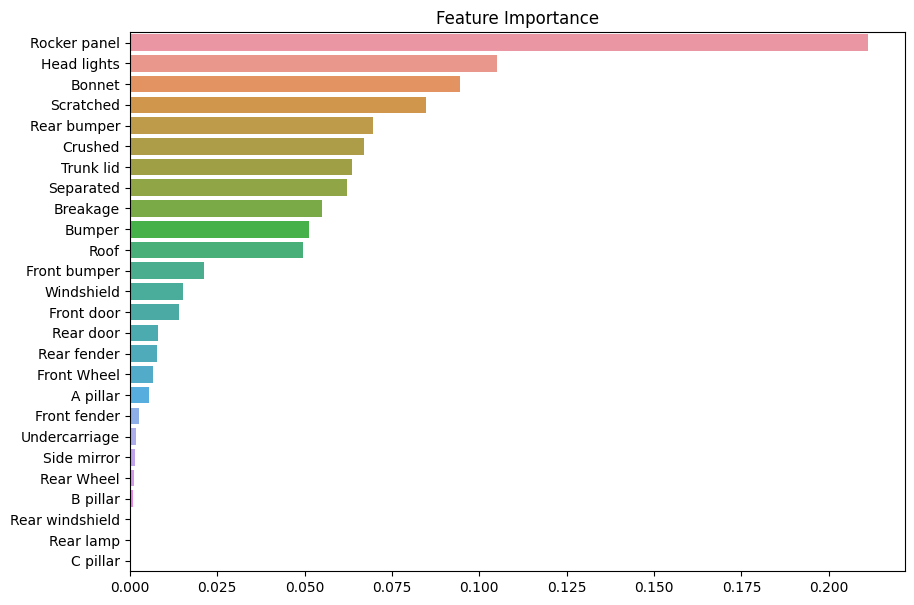

In [32]:
rf_importance_values = best_rf_model.feature_importances_

rf_series = pd.Series(rf_importance_values, index = X_train_normalized.columns)
rf_series.sort_values(ascending = False, inplace = True)

plt.figure(figsize = (10,7))
plt.title('Feature Importance')
sns.barplot(x = rf_series, y = rf_series.index)
plt.show()

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

# MLPRegressor basic

In [15]:
model = MLPRegressor(hidden_layer_sizes=(10,),  # 은닉층 크기
                     activation='relu',  # 활성화 함수
                     solver='adam',  # 최적화 알고리즘
                     alpha=0.0001,  # L2 정규화 강도
                     learning_rate='constant',  # 학습률 스케줄링 방법
                     max_iter=500,  # 최대 반복 횟수
                     random_state=42)  # 랜덤 시드 값

model.fit(X_train_normalized, y_train)

y_train_pred = model.predict(X_train_normalized)
y_valid_pred = model.predict(X_valid_normalized)
y_test_pred = model.predict(X_test_normalized)

# 예측 결과 평가
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("예측 결과:")
print("훈련 데이터에 대한 RMSE:", rmse_train)
print("검증 데이터에 대한 RMSE:", rmse_valid)                    
print("테스트 데이터에 대한 RMSE:", rmse_test)

예측 결과:
훈련 데이터에 대한 RMSE: 379090.09284997464
검증 데이터에 대한 RMSE: 352255.28556274716
테스트 데이터에 대한 RMSE: 382323.5350505796


/home/piai/miniconda3/envs/project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
